<a href="https://colab.research.google.com/github/ccchen-jerry/stock_modeling/blob/main/00_LSTM_Metrology_findings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shioaji

## **Packages**

In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import shioaji as sj

from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [ ]:

# Calling Shioaji api & login
api = sj.Shioaji()
api.login(
    person_id="", 
    passwd="", 
    contracts_cb=lambda security_type: print(f"{repr(security_type)} fetch done.")
)

# **API test**

In [ ]:
today = datetime.today() - timedelta(days=3)
today = today.strftime("%Y-%m-%d")
# company = "2409" #AUO
company = "2330" #TSMC

contract = api.Contracts.Stocks[company]
print(contract)

ticks = api.ticks(api.Contracts.Stocks[company], today)
print(ticks)

exchange=<Exchange.TSE: 'TSE'> code='2330' symbol='TSE2330' name='台積電' category='24' unit=1000 limit_up=653.0 limit_down=535.0 reference=594.0 update_date='2021/08/27' margin_trading_balance=1246 short_selling_balance=218 day_trade=<DayTrade.Yes: 'Yes'>
ts=[1629968403927272000, 1629968403961890000, 1629968403972107000, 1629968403974737000, 1629968403978345000, 1629968403978677000, 1629968403987466000, 1629968404004839000, 1629968404011444000, 1629968404015613000, 1629968404098719000, 1629968404102454000, 1629968404111971000, 1629968404112413000, 1629968404113849000, 1629968404125207000, 1629968404133134000, 1629968404139726000, 1629968404144593000, 1629968404149128000, 1629968404154786000, 1629968404158996000, 1629968404159133000, 1629968404175056000, 1629968404177208000, 1629968404179836000, 1629968404182714000, 1629968404187507000, 1629968404190090000, 1629968404207935000, 1629968404247141000, 1629968404284186000, 1629968404284740000, 1629968404285437000, 1629968404287192000, 1629968

# **Functions**

In [ ]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv_scaled, \
                          scaler, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv_scaled     : actual value of the predictions (scaled)
        scaler          : scaler that is used to fit_transform train set
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = scaler.inverse_transform(est_scaled)
    
    # Get correct scale of y_cv
    y_cv = scaler.inverse_transform(y_cv_scaled)

    # Calculate RMSE and MAPE
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

# Rawdata from api

In [ ]:
target_company = "2330"
startdate = "2020-06-01"
enddate = "2021-07-01"


kbars = api.kbars(api.Contracts.Stocks[target_company], start=startdate, end=enddate)
df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)

In [ ]:
df_price = df.groupby([df['ts'].dt.date])['Close', 'Open', 'High', 'Low'].mean()
df_volume = df.groupby([df['ts'].dt.date])['Volume'].sum()
df = pd.concat([df_price, df_volume], axis=1)
df['date'] = df.index
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Close,Open,High,Low,Volume,date
ts,,,,,,
2020-06-01,295.639098,295.635338,295.924812,295.387218,35694,2020-06-01
2020-06-02,296.599624,296.586466,296.881579,296.381579,24680,2020-06-02
2020-06-03,299.500000,299.481203,299.731203,299.191729,64892,2020-06-03
2020-06-04,305.003759,305.003759,305.317669,304.793233,46316,2020-06-04
2020-06-05,309.471805,309.488722,309.750000,309.236842,42644,2020-06-05
...,...,...,...,...,...,...
2021-06-25,592.966165,593.018797,593.609023,592.646617,18773,2021-06-25
2021-06-28,587.515038,587.582707,588.063910,587.067669,14972,2021-06-28
2021-06-29,594.469925,594.507519,595.067669,594.022556,28621,2021-06-29


Text(0, 0.5, 'NTD')

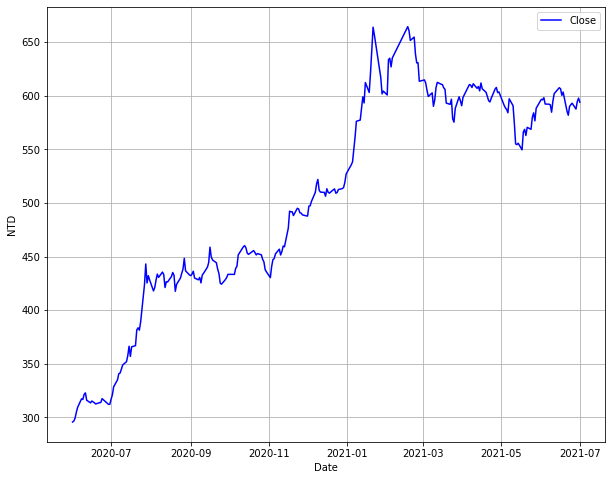

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("NTD")

In [ ]:
#### Input params ##################
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units = 50                  # lstm param. initial value before tuning.
dropout_prob = 0.2                 # lstm param. initial value before tuning.
optimizer = 'adam'               # lstm param. initial value before tuning.
epochs = 1                       # lstm param. initial value before tuning.
batch_size = 1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
set_seed(model_seed)

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'Close']]
cv = df[num_train:num_train+num_cv][['date', 'Close']]
train_cv = df[:num_train+num_cv][['date', 'Close']]
test = df[num_train+num_cv:][['date', 'Close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 160
num_cv = 53
num_test = 53
train.shape = (160, 2)
cv.shape = (53, 2)
train_cv.shape = (213, 2)
test.shape = (53, 2)


In [ ]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train['Close']).reshape(-1,1))
print("scaler.data_min_ = " + str(scaler.data_min_))
print("scaler.data_max_ = " + str(scaler.data_max_))

# Split into x and y
x_train, y_train = get_x_y(train_scaled, N, N)
print("x_train.shape = " + str(x_train.shape)) # (446, 7, 1)
print("y_train.shape = " + str(y_train.shape)) # (446, 1)

# x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # (446, 7, 1)
# print("x_train.shape = " + str(x_train.shape))

scaler.data_min_ = [295.63909774]
scaler.data_max_ = [612.26691729]
x_train.shape = (151, 9, 1)
y_train.shape = (151, 1)


In [ ]:
# Scale the cv dataset according the min and max obtained from train set
train_cv_scaled  = scaler.transform(np.array(train_cv['Close']).reshape(-1,1))

# Split into x and y
x_cv, y_cv = get_x_y(train_cv_scaled, N, num_train)
print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

# Scale the cv dataset according the min and max obtained from train set
train_cv_scaled  = scaler.transform(np.array(train_cv['Close']).reshape(-1,1))

# Split into x and y
x_cv, y_cv = get_x_y(train_cv_scaled, N, num_train)
print("x_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))

# Here we scale the train_cv set, for the final model
scaler_final = MinMaxScaler(feature_range=(0, 1))
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['Close']).reshape(-1,1))
print("scaler_final.data_min_ = " + str(scaler_final.data_min_))
print("scaler_final.data_max_ = " + str(scaler_final.data_max_))

# Scale the test dataset according the min and max obtained from train_cv set
test_scaled  = scaler_final.transform(np.array(df['Close']).reshape(-1,1))

x_cv.shape = (53, 9, 1)
y_cv.shape = (53, 1)
x_cv.shape = (53, 9, 1)
y_cv.shape = (53, 1)
scaler_final.data_min_ = [295.63909774]
scaler_final.data_max_ = [664.33082707]


In [ ]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 9, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

151/151 - 11s - loss: 0.0279


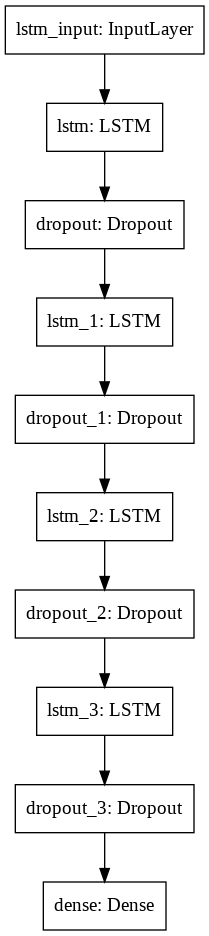

In [ ]:
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
# Plot model and save to file
plot_model(model, to_file='model.png')

In [ ]:
# Do prediction
est = model.predict(x_cv)
est_inv = scaler.inverse_transform(est)

# Get correct scale of y_cv
y_cv_inv = scaler.inverse_transform(y_cv)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv_inv, est_inv))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv_inv, est_inv)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

RMSE = 34.336
MAPE = 4.717%


Text(0, 0.5, 'NTD')

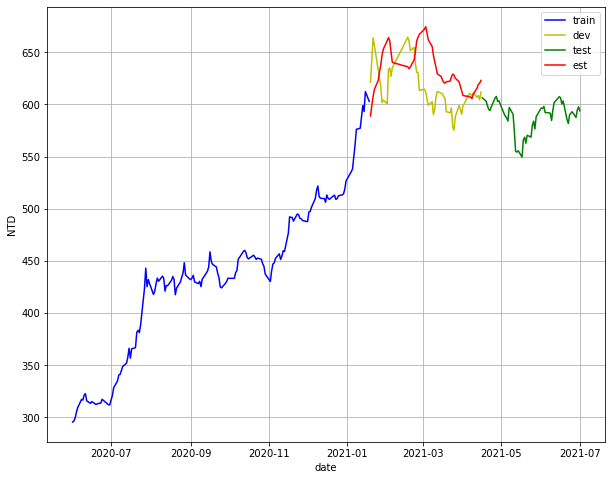

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est_inv': est_inv.reshape(-1), 
                       'y_cv_inv': y_cv_inv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='Close', style='b-', grid=True)
ax = cv.plot(x='date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est_inv', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("NTD")

In [ ]:
param_label = 'N'
param_list = range(2, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv_scaled, \
                                          scaler, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer='adam', \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/58 [00:00<?, ?it/s]

Minutes taken = 3.5693436662356057


,N,rmse,mape_pct
0,2,28.489878,3.984158
1,3,44.731924,6.714624
2,4,19.447912,2.566236
3,5,22.058379,2.895015
4,6,39.023166,5.533599
5,7,26.557376,3.385067
6,8,24.439119,3.143398
7,9,24.527891,3.047178
8,10,26.861346,3.346618
9,11,28.779905,3.568654


Text(0, 0.5, 'RMSE/MAPE(%)')

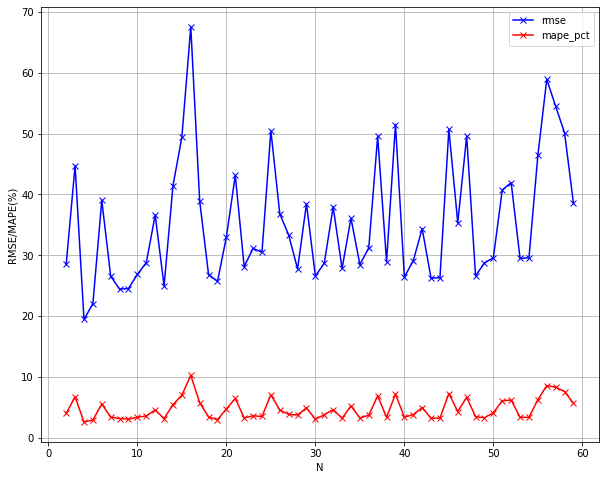

In [ ]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 19.448
min MAPE = 2.566%
optimum N = 4


## **Tunning model** -- epochs and batch_size


In [ ]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv_scaled = get_x_y(train_cv_scaled, N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer='adam', \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 2.190819183985392


,epochs,batch_size,rmse,mape_pct
0,1,8,44.207931,6.537378
1,1,16,216.517331,35.013317
2,1,32,273.239497,44.252692
3,1,64,293.979310,47.630203
4,1,128,297.556055,48.213417
5,10,8,42.417081,6.074226
6,10,16,37.512247,5.232048
7,10,32,43.047490,6.333882
8,10,64,39.240916,5.650960
9,10,128,26.159615,3.257742


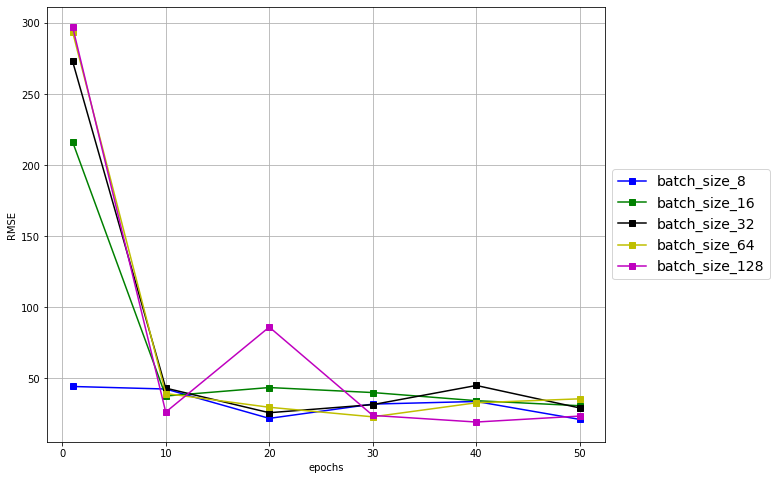

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 19.170
min MAPE = 2.517%
optimum epochs = 40
optimum batch_size = 128


## **Tunning model** -- LSTM units and dropout prob


In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer='adam', \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 1.330330765247345


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,124.064589,19.869822
1,10,0.6,142.746473,22.924373
2,10,0.7,174.585802,28.133326
3,10,0.8,168.988016,27.228394
4,10,0.9,235.587567,38.100438
5,50,0.5,20.405495,2.611583
6,50,0.6,29.153615,3.787664
7,50,0.7,52.100021,7.906699
8,50,0.8,62.522143,9.707330
9,50,0.9,106.525867,17.019343


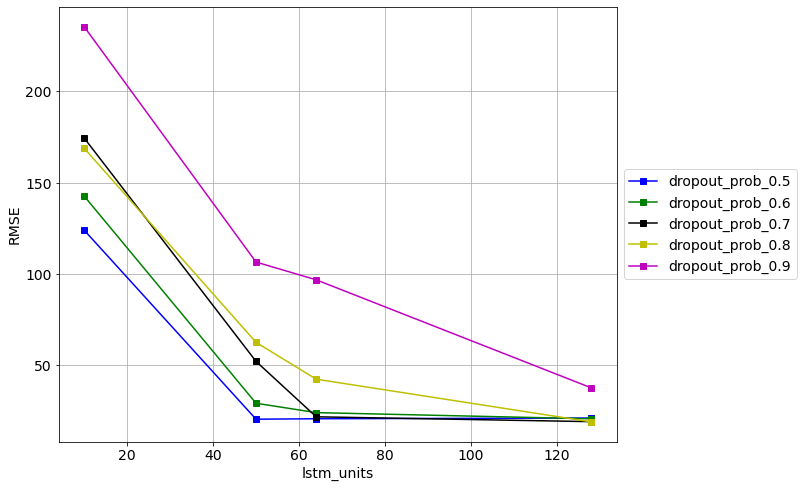

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 18.931
min MAPE = 2.490%
optimum lstm_units = 128
optimum dropout_prob = 0.8


## **Tunning model** -- optimizer


In [ ]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units_opt, \
                                              dropout_prob=dropout_prob_opt, \
                                              optimizer=param, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7 [00:00<?, ?it/s]

Minutes taken = 0.47001060644785564


,optimizer,rmse,mape_pct
0,adam,19.409222,2.508451
1,sgd,183.281995,29.514176
2,rmsprop,24.009947,3.172605
3,adagrad,268.542524,43.473798
4,adadelta,325.590499,52.773642
5,adamax,36.986433,5.215177
6,nadam,32.912045,4.508737


Text(0, 0.5, 'RMSE/MAPE(%)')

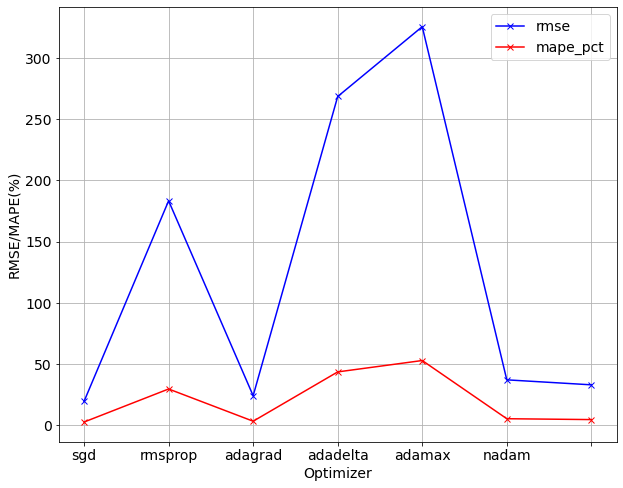

In [ ]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 19.409
min MAPE = 2.508%
optimum optimizer = adam


## **Tuned results**

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,4
1,lstm_units,50,128
2,dropout_prob,0.2,0.8
3,optimizer,adam,adam
4,epochs,1,40
5,batch_size,1,128
6,rmse,34.336,19.4092
7,mape_pct,4.71718,2.50845


## **Final Model**

In [ ]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test_scaled = get_x_y(test_scaled, N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test_scaled, \
                                        scaler_final, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 14.015
MAPE on test set = 2.060%


Text(0, 0.5, 'NTD')

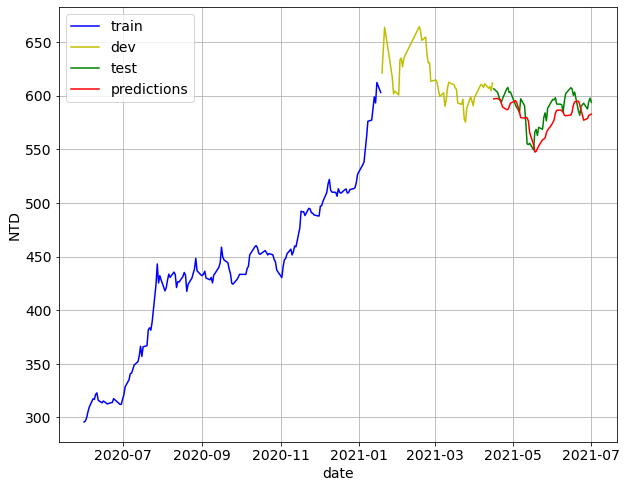

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='Close', style='b-', grid=True)
ax = cv.plot(x='date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("NTD")

Text(0.5, 1.0, 'Zoom in to test set')

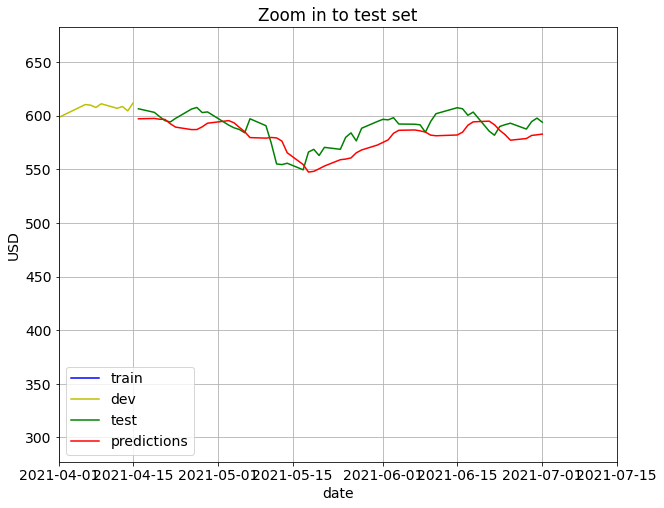

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='Close', style='b-', grid=True)
ax = cv.plot(x='date', y='Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 4, 1), date(2021, 7, 15)])
# ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")